# What technologies should you learn to land one of the Top-3 in-demand roles?
- Likelihood of Technologies Requested for Top-3 Data Roles in Europe
- Number of skills requested for each of Top-3 Data Roles in Europe

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import ast

from collections import Counter

df = pd.read_csv('/Users/kolesnikevgenia/Documents/Python_Projects/Job_Skills/Raw_Data/df_Final.csv')

In [4]:
df_technology = df['job_type_skills'].copy()

df_technology = df_technology.drop_duplicates()
df_technology = df_technology.dropna()

#combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

#remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')
df_technology.head(5)

,technology,skills
0,analyst_tools,visio
0,analyst_tools,datarobot
0,analyst_tools,sap
0,analyst_tools,ssrs
0,analyst_tools,ssis


In [5]:
df_dropna = df.dropna(subset=['job_skills']).copy()
df_dropna['job_skills'] = df_dropna['job_skills'].apply(ast.literal_eval)
df_exploded = df_dropna.explode('job_skills')
df_plot = df_exploded.merge(df_technology, left_on='job_skills', right_on='skills').copy()
df_plot.head(5)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,...,company_name,job_skills,job_type_skills,salary_year_avg_eur,salary_month_avg_eur,country,is_eu,region_group,technology,skills
0,Data Scientist,CRM Data Specialist,"San José Province, San José, Costa Rica",via Ai-Jobs.net,Full-time,False,Costa Rica,2023-08-01 13:37:57,False,False,...,Netskope,gdpr,"{'analyst_tools': ['excel'], 'libraries': ['gd...",96447.6,8037.3,NaN,False,Other,libraries,gdpr
1,Data Scientist,CRM Data Specialist,"San José Province, San José, Costa Rica",via Ai-Jobs.net,Full-time,False,Costa Rica,2023-08-01 13:37:57,False,False,...,Netskope,excel,"{'analyst_tools': ['excel'], 'libraries': ['gd...",96447.6,8037.3,NaN,False,Other,analyst_tools,excel
2,Data Engineer,Data Engineer,"Arlington, VA",via LinkedIn,Full-time,False,Sudan,2023-06-26 14:22:54,False,False,...,Intelletec,mongodb,"{'analyst_tools': ['tableau'], 'cloud': ['orac...",123312.0,10276.0,NaN,False,Other,databases,mongodb
3,Data Engineer,Data Engineer,"Arlington, VA",via LinkedIn,Full-time,False,Sudan,2023-06-26 14:22:54,False,False,...,Intelletec,mongodb,"{'analyst_tools': ['tableau'], 'cloud': ['orac...",123312.0,10276.0,NaN,False,Other,programming,mongodb
4,Data Engineer,Data Engineer,"Arlington, VA",via LinkedIn,Full-time,False,Sudan,2023-06-26 14:22:54,False,False,...,Intelletec,mongodb,"{'analyst_tools': ['tableau'], 'cloud': ['orac...",123312.0,10276.0,NaN,False,Other,databases,mongodb


In [25]:
import pandas as pd
import plotly.express as px

# Step 1: Filter relevant data
top_roles = ['Data Analyst', 'Data Scientist', 'Data Engineer']
df_filtered = df_plot[
    (df_plot['region_group'] == 'EU') &
    (df_plot['job_title_short'].isin(top_roles)) &
    (df_plot['technology'].notna())
]

# Step 2: Explode technologies into individual rows
df_exploded = (
    df_filtered
    .assign(technology=df_filtered['technology'].str.split(', '))
    .explode('technology')
)

# Step 3: Calculate top 5 technologies per role (normalized)
top_tech_list = []
for role in top_roles:
    tech_counts = (
        df_exploded[df_exploded['job_title_short'] == role]['technology']
        .value_counts(normalize=True)
        .head(5)
        .reset_index()
    )
    tech_counts.columns = ['technology', 'percentage']
    tech_counts['job_title_short'] = role
    top_tech_list.append(tech_counts)

# Step 4: Combine into one DataFrame and add percentage labels
df_top_tech = pd.concat(top_tech_list, ignore_index=True)
df_top_tech['percentage_label'] = (df_top_tech['percentage'] * 100).round(0).astype(int).astype(str) + '%'

# Step 5: Plot with Plotly Express (faceted by column instead of row)
fig = px.bar(
    df_top_tech,
    x='technology',
    y='percentage',
    color='technology',
    facet_col='job_title_short',
    text='percentage_label',
    title='Top 5 Technologies per Role in EU (Percentage of Postings)',
    labels={'technology': '', 'percentage': 'Percentage of Job Postings'},
    color_discrete_sequence=px.colors.sequential.Blues
)

# Step 6: Update layout
fig.update_traces(textposition='outside')
fig.update_layout(
    height=500,
    showlegend=False,
    margin=dict(l=40, r=20, t=80, b=60)
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # Clean facet titles

fig.show()

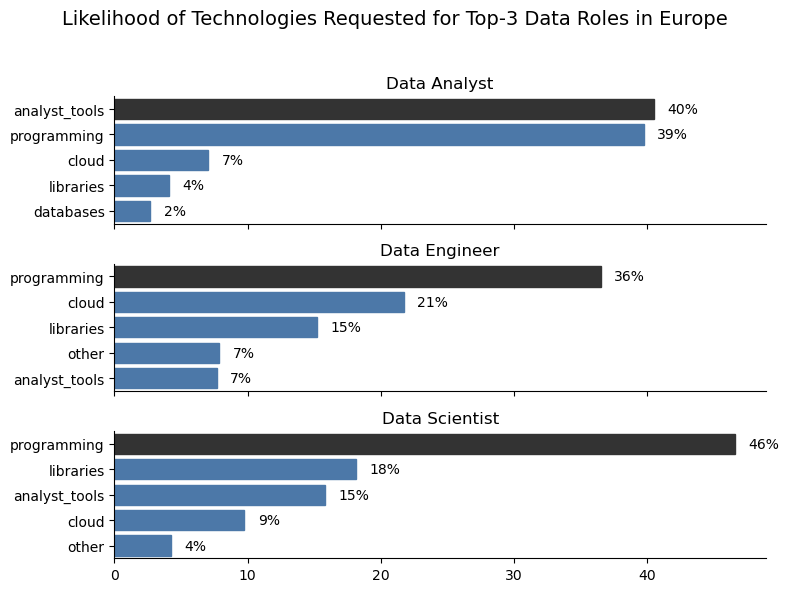

In [12]:
# Filter data
top_roles = ['Data Analyst', 'Data Engineer', 'Data Scientist']
df_plot_top3 = df_plot[df_plot['job_title_short'].isin(top_roles) & df_plot['technology'].notna()]

# Define color palette
black_color = '#333333'
blue_color = '#4c78a8'

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
fig.suptitle('Likelihood of Technologies Requested for Top-3 Data Roles in Europe', fontsize=14)

# Loop through each role
for ax, role in zip(axes, top_roles):
    skill_series = (
        df_plot_top3[df_plot_top3['job_title_short'] == role]['technology']
        .str.split(', ')
        .explode()
    )
    
    skill_counts = skill_series.value_counts(normalize=True).head(5)  # Top 5
    colors = [black_color if i == 0 else blue_color for i in range(len(skill_counts))]
    
    sns.barplot(
        x=skill_counts.values * 100,
        y=skill_counts.index,
        ax=ax,
        color=blue_color  # default bar color
    )

    # Color just the top bar (first one) manually
    for bar, c in zip(ax.patches, colors):
        bar.set_color(c)
    
    # Annotate bars
    for i, (val, skill) in enumerate(zip(skill_counts.values, skill_counts.index)):
        ax.text(val * 100 + 1, i, f'{int(val*100)}%', va='center')

    ax.set_title(role)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Clean up layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()
plt.show()

### Number of skills requested for each of Top-3 Data Roles in Europe

In [21]:
# Step 1: Define function to count skills
def count_skills(skills_str):
    if pd.isna(skills_str) or skills_str.strip() == '':
        return 0
    return len([s for s in skills_str.split(',') if s.strip() != ''])

# Step 2: Add a skills_count column
df['skills_count'] = df['job_skills'].apply(count_skills)

# Step 3: Filter for EU region and top 3 roles
top_roles = ['Data Analyst', 'Data Scientist', 'Data Engineer']
filtered_df = df[
    (df['region_group'] == 'EU') &
    (df['job_title_short'].isin(top_roles))
]

# Step 4: Calculate average number of skills per role
avg_skills_per_role = (
    filtered_df.groupby('job_title_short')['skills_count']
    .mean()
    .reset_index()
    .rename(columns={'skills_count': 'avg_skills'})
    .sort_values(by='avg_skills', ascending=False)
)

# Display result
print(avg_skills_per_role)

  job_title_short  avg_skills
1   Data Engineer    6.722689
2  Data Scientist    4.392982
0    Data Analyst    3.481959
